In [1]:
# Colab Venn Diagram
!pip install -q matplotlib-venn

In [3]:
import io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from google.colab import files

In [4]:
uploaded = files.upload()
file_path = list(uploaded.keys())[0]
data = pd.ExcelFile(file_path)

Saving Venndiagram_data.xlsx to Venndiagram_data.xlsx


In [8]:
# Read Sheet1
df = data.parse('Sheet 1')

In [9]:
display(df.head())

,Protein IDs,Alpha A30P_day_1,Alpha A53T_day_1,Alpha _day_1
0,Q8T008;A8DY95;A1Z8A7,-0.839753,NaN,NaN
1,P12252-4;P12252-5;P12252;E2QD73;P12252-6;P1225...,-2.092368,NaN,-1.453550
2,Q9VIC9,NaN,NaN,NaN
3,Q7YU24;O18412,-1.310763,-1.030288,-1.119664
4,P08255,-0.655028,NaN,NaN


In [10]:
# Sanity check: ensure expected columns exist
#expected_cols = {"Gene Name", "Sample A", "Sample B", "Sample C"}
#missing = expected_cols - set(df.columns)
#if missing:
    #raise ValueError(f"Missing expected columns: {missing}. Found columns: {list(df.columns)}")

In [34]:
# Define presence rule
THRESH = 0   # treat values > THRESH as present
A_A30P_D1 = set(df.loc[df[" Alpha A30P_day_1"].notna() & (df[" Alpha A30P_day_1"] > THRESH), "Protein IDs"].astype(str))
A_A53T_D1 = set(df.loc[df[" Alpha A53T_day_1"].notna() & (df[" Alpha A53T_day_1"] > THRESH), "Protein IDs"].astype(str))
A_D1 = set(df.loc[df[" Alpha _day_1"].notna() & (df[" Alpha _day_1"] > THRESH), "Protein IDs"].astype(str))


In [35]:
# Build & save Venn diagram
only_A_A30P_D1 = len(A_A30P_D1 - A_A53T_D1 - A_D1)
only_A_A53T_D1 = len(A_A53T_D1 - A_A30P_D1 - A_D1)
A_A30P_D1_A_A53T_D1    = len((A_A30P_D1 & A_A53T_D1) - A_D1)
only_A_D1 = len(A_D1 - A_A30P_D1 - A_A53T_D1)
A_A30P_D1_A_D1    = len((A_A30P_D1 & A_D1) - A_A53T_D1)
A_A53T_D1_A_D1    = len((A_A53T_D1 & A_D1) - A_A30P_D1)
A_A30P_D1_A_A53T_D1_A_D1  = len(A_A30P_D1 & A_A53T_D1 & A_D1)

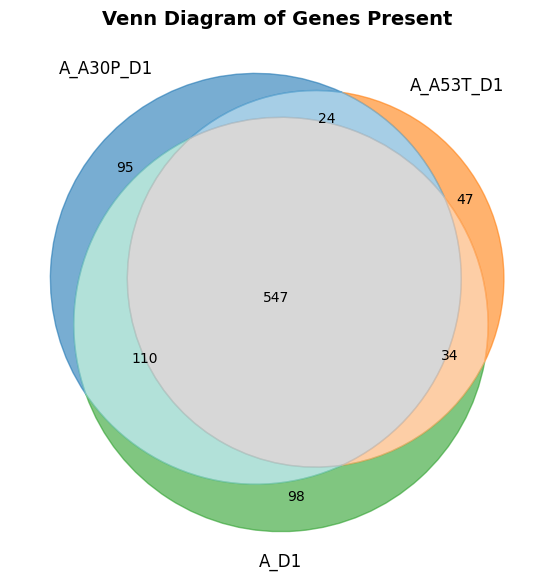

In [36]:
# Plot
plt.figure(figsize=(7,7))
v = venn3(subsets=(only_A_A30P_D1, only_A_A53T_D1, A_A30P_D1_A_A53T_D1, only_A_D1, A_A30P_D1_A_D1 , A_A53T_D1_A_D1, A_A30P_D1_A_A53T_D1_A_D1),
          set_labels=("A_A30P_D1", "A_A53T_D1", "A_D1"))


# Apply custom colors
v.get_patch_by_id('100').set_color('#1f77b4')  # A only (blue)
v.get_patch_by_id('010').set_color('#ff7f0e')  # B only (orange)
v.get_patch_by_id('001').set_color('#2ca02c')  # C only (green)
v.get_patch_by_id('110').set_color('#6baed6')  # A∩B
v.get_patch_by_id('101').set_color('#80cdc1')  # A∩C
v.get_patch_by_id('011').set_color('#fdae6b')  # B∩C
v.get_patch_by_id('111').set_color('#bdbdbd')  # A∩B∩C


# set transparency for all areas
for patch in v.patches:
    if patch:
        patch.set_alpha(0.6)

plt.title("Venn Diagram of Genes Present", fontsize=14, fontweight='bold')

# Save outputs
png_path = "Venn_Sheet1_colored.png"
pdf_path = "Venn_Sheet1_colored.pdf"
plt.savefig(png_path, dpi=600, format="png")
plt.savefig(pdf_path, format="pdf")
plt.show()

In [17]:
# Define a function to get genes for a given subset
def genes_for(subset_id):
    if subset_id == '100':
        return list(set_A - set_B - set_C)
    elif subset_id == '010':
        return list(set_B - set_A - set_C)
    elif subset_id == '001':
        return list(set_C - set_A - set_B)
    elif subset_id == '110':
        return list((set_A & set_B) - set_C)
    elif subset_id == '101':
        return list((set_A & set_C) - set_B)
    elif subset_id == '011':
        return list((set_B & set_C) - set_A)
    elif subset_id == '111':
        return list(set_A & set_B & set_C)
    else:
        return []

# Export gene lists
pd.Series(genes_for('100')).to_csv("only_A.csv", index=False, header=["Gene"])
pd.Series(genes_for('010')).to_csv("only_B.csv", index=False, header=["Gene"])
pd.Series(genes_for('001')).to_csv("only_C.csv", index=False, header=["Gene"])
pd.Series(genes_for('110')).to_csv("A_B.csv", index=False, header=["Gene"])
pd.Series(genes_for('101')).to_csv("A_C.csv", index=False, header=["Gene"])
pd.Series(genes_for('011')).to_csv("B_C.csv", index=False, header=["Gene"])
pd.Series(genes_for('111')).to_csv("A_B_C.csv", index=False, header=["Gene"])

# Download results
for f in [png_path, pdf_path, "only_A.csv", "only_B.csv", "only_C.csv","A_B.csv","A_C.csv","B_C.csv","A_B_C.csv"]:
    files.download(f)


print(f"Only A: {only_A}")
print(f"Only B: {only_B}")
print(f"Only C: {only_C}")
print(f"A and B (not C): {A_B}")
print(f"A and C (not B): {A_C}")
print(f"B and C (not A): {B_C}")
print(f"A, B, and C: {A_B_C}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only A: 95
Only B: 47
Only C: 98
A and B (not C): 24
A and C (not B): 110
B and C (not A): 34
A, B, and C: 547


In [24]:
proteins_A_B_not_C = list((set_A & set_B) - set_C)
print(f"Proteins common to Sample A and Sample B (but not Sample C) ({len(proteins_A_B_not_C)} total):\n{proteins_A_B_not_C}")

Proteins common to Sample A and Sample B (but not Sample C) (24 total):
['P20348-2;P20348', 'O97102', 'A1Z722', 'P29844', 'P11997', 'Q9VRD6;A8JUT4;Q9VJ85', 'P26686-2', 'Q9VJ46', 'Q7JVK8', 'Q9VWA1;E1JI22', 'Q8SXR1', 'Q5U124;Q8T0N3', 'Q9VEK7;Q8IN97', 'Q9VZ64', 'Q9NEF6', 'Q7JXF7', 'Q9VJH8;Q9VJI0;Q9VJH9', 'Q9W259', 'Q9VY92', 'Q9VHE4', 'Q7K1I4', 'A1Z9F9;Q7JWE2', 'P48375', 'Q24509;A4V0S1']
